# Preprocessing steps analysis for Stanford datasets

### Import modules and define methods

In [1]:
%reload_ext autoreload
%autoreload 2

import os
from preprocess import *
from argparse import Namespace
import skimage.exposure as exp
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import subtle.utils.io as suio
from glob import glob

plt.set_cmap('gray')
plt.rcParams['figure.figsize'] = (10, 8)

from tqdm import tqdm_notebook as tqdm
import subtle.subtle_preprocess as supre

metadata={
    'lambda': []
}

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

def show_img(img, title='', axis=False, vmin=None, vmax=None):
    imshow_args = {}
    
    if vmin:
        imshow_args['vmin'] = vmin
    if vmax:
        imshow_args['vmax'] = vmax
    
    im_axis = 'on' if axis else 'off'
    plt.axis(im_axis)
    plt.imshow(img, **imshow_args)
    plt.title(title, fontsize=15)

def show_gad_comparison(img_pre, img_low, img_post, vmin=None, vmax=None):
    fig = plt.figure(figsize=(15, 10))
    fig.tight_layout()

    fig.add_subplot(1, 3, 1)
    show_img(img_pre, title='Pre contrast', vmin=vmin, vmax=vmax)

    fig.add_subplot(1, 3, 2)
    show_img(img_low, title='10% dosage', vmin=vmin, vmax=vmax)

    fig.add_subplot(1, 3, 3)
    show_img(img_post, title='Full dosage', vmin=vmin, vmax=vmax)

    plt.show()

def show_comparison(img1, img2, titles=['', ''], vmin=None, vmax=None):
    fig = plt.figure(figsize=(15, 10))
    fig.tight_layout()

    fig.add_subplot(1, 2, 1)
    show_img(img1, title=titles[0], vmin=vmin, vmax=vmax)

    fig.add_subplot(1, 2, 2)
    show_img(img2, title=titles[1], vmin=vmin, vmax=vmax)
    
    plt.show()

def iminfo(img):
    print(img.shape, img.dtype, img.min(), img.max(), img.mean())

def diff_img(img1, img2, abs_diff=True):
    diff = np.subtract(img1.astype(np.float32), img2.astype(np.float32))
    if not abs_diff:
        return diff
    
    # return np.abs(diff).astype(np.float32)
    return diff

def show_hist(img, nbins=512, title=''):
    rav = img.ravel()
    rav = rav[rav != 0]
    plt.hist(rav, bins=nbins, log=True)
    plt.title(title)
    plt.xlabel('Pixel values')
    plt.ylabel('log10 Count')
    plt.show()

def show_final_comparison(img_pre, img_low, img_post):
    fig = plt.figure(figsize=(15, 12))
    fig.tight_layout()
    
    imstack = np.hstack((img_pre, img_low, img_post))
    abs_diff = True
    
    scale_factor = 5
    
    diff0 = diff_img(img_pre, img_pre, abs_diff)
    diff1 = diff_img(img_low, img_pre, abs_diff)
    diff2 = diff_img(img_post, img_pre, abs_diff)
    
    diff = np.hstack((diff0, diff1 * scale_factor, diff2 * scale_factor))
    
    final_disp = np.vstack((imstack, diff))
    
    show_img(final_disp, vmin=imstack.min(), vmax=imstack.max())

/home/srivathsa/miniconda3/envs/py35gad/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/srivathsa/miniconda3/envs/py35gad/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/srivathsa/miniconda3/envs/py35gad/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/srivathsa/miniconda3/envs

<Figure size 432x288 with 0 Axes>

### Initialize dummy argparse Namespace

In [15]:
args = Namespace(
    path_base='/home/srivathsa/projects/studies/gad/bracco/dcms/1231970', verbose=True,
    output='/home/srivathsa/projects/studies/gad/stanford/preprocess/data/dummy.h5',
    discard_start_percent=0, discard_end_percent=0, normalize=True,
    normalize_fun='mean', transform_type='affine', scale_matching=True,
    path_zero=None, 
    path_low=None, 
    path_full=None, mask_threshold=0.05,
    override=True, skip_mask=False, scale_dicom_tags=False, skip_hist_norm=False,
    skip_registration=False, nslices=20, joint_normalize=False, global_scale_ref_im0=False, noise_mask_area=False,
    fsl_mask=True, fsl_mask_all_ims=True, use_fsl_reg=False, fsl_threshold=0.5, blur_for_cs_streaks=False,
    union_brain_masks=False, register_with_dcm_reference=True, reg_n_levels=4
)

### Fetch original images

In [3]:
ims, hdr, metadata = get_images(args, metadata)
# ims = ims.transpose(2, 1, 0, 3)
# ims = np.rot90(ims, axes=(2, 3), k=2)
orig_ims = np.copy(ims)
pidx = ims.shape[0] // 2

path_zero = /home/srivathsa/projects/studies/gad/bracco/dcms/1231970/6_st1w_3d_ffe+c
path_low = /home/srivathsa/projects/studies/gad/bracco/dcms/1231970/8_st1w_3d_ffe+c
path_full = /home/srivathsa/projects/studies/gad/bracco/dcms/1231970/8_st1w_3d_ffe+c
image sizes:  (180, 512, 512) (180, 512, 512) (180, 512, 512)
image sizes after resize:  (180, 512, 512) (180, 512, 512) (180, 512, 512)


(180, 512, 512) float32 0.0 1436.0 43.092564
(180, 512, 512) float32 0.0 2173.0 80.29948
(180, 512, 512) float32 0.0 2173.0 80.29948


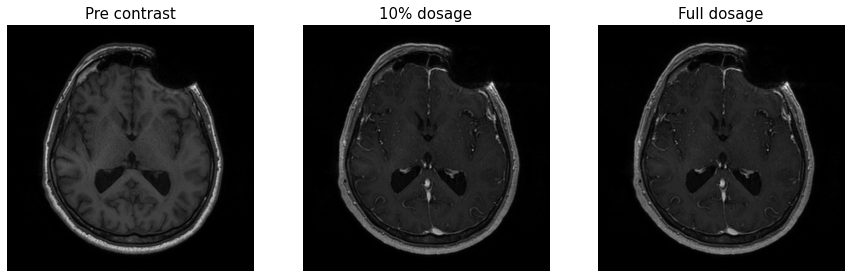

In [4]:
iminfo(ims[:, 0])
iminfo(ims[:, 1])
iminfo(ims[:, 2])

show_gad_comparison(ims[pidx, 0], ims[pidx, 1], ims[pidx, 2])

### Mask images

In [6]:
ims, mask, metadata = mask_images(args, ims, metadata)

masking


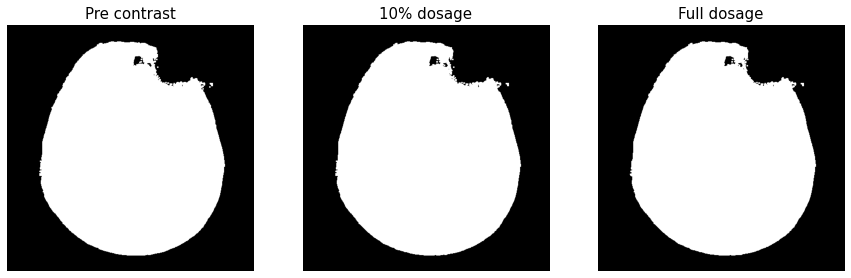

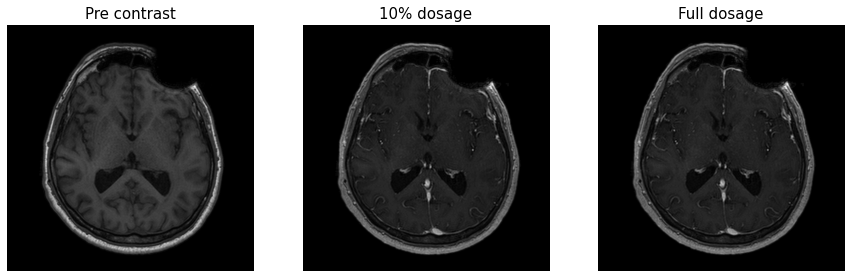

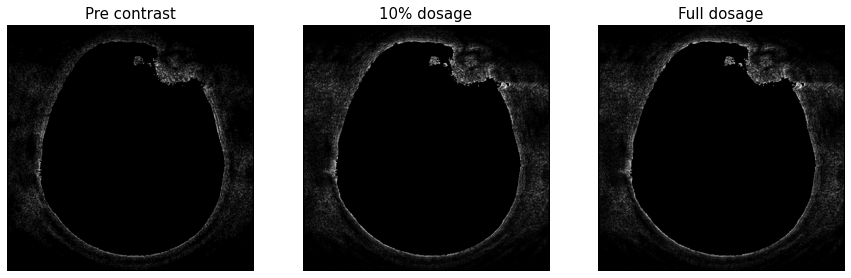

In [7]:
show_gad_comparison(mask[pidx, 0], mask[pidx, 1], mask[pidx, 2])
show_gad_comparison(ims[pidx, 0], ims[pidx, 1], ims[pidx, 2])

pre_diff = diff_img(orig_ims[pidx, 0], ims[pidx, 0])
low_diff = diff_img(orig_ims[pidx, 1], ims[pidx, 1])
post_diff = diff_img(orig_ims[pidx, 2], ims[pidx, 2])

show_gad_comparison(pre_diff, low_diff, post_diff)

In [8]:
fsl_mask = fsl_brain_mask(args, ims)

Extracting brain regions using deepbrain...
BET Zero


Instructions for updating:
Use tf.gfile.GFile.

BET Low
BET Full


In [9]:
ims_mask = apply_fsl_mask(args, ims, fsl_mask)

Applying computed FSL masks on images. Mask shape - (180, 3, 512, 512)


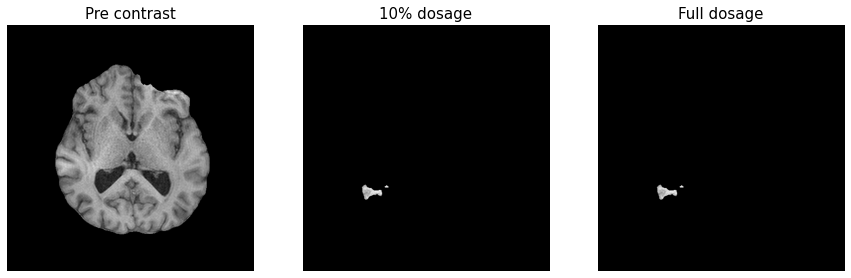

In [10]:
show_gad_comparison(ims_mask[pidx, 0], ims_mask[pidx, 1], ims_mask[pidx, 2])

In [11]:
ref_zero = sup.dcm_to_sitk(args.path_zero)
ref_low = sup.dcm_to_sitk(args.path_low)
ref_full = sup.dcm_to_sitk(args.path_full)

In [ ]:
print(ref_zero.GetDirection())
print(ref_low.GetDirection())

In [12]:
import SimpleITK as sitk

pm = sitk.GetDefaultParameterMap('affine', 4)
reg_ims = np.copy(ims_mask)

reg_ims[:, 1], param_map = sup.register_im(ims[:, 0], ims[:, 1], param_map=pm, verbose=1, 
                               im_fixed_spacing=metadata['pixel_spacing_zero'], 
                               im_moving_spacing=metadata['pixel_spacing_low'],
                               ref_fixed=ref_zero, ref_moving=ref_low)

# reg_ims[:, 2], param_map = sup.register_im(ims[:, 0], ims[:, 2], param_map=pm, verbose=1,
#                                            im_fixed_spacing=metadata['pixel_spacing_zero'], 
#                                            im_moving_spacing=metadata['pixel_spacing_full'],
#                                           ref_fixed=ref_zero, ref_moving=ref_full)

print(param_map[0]['TransformParameters'])

image registration
registration done, 10.9 s
('1.00112', '0.000121082', '0.000743449', '0.000547018', '1.00117', '-0.000872574', '-0.000942767', '-0.000130799', '1.00226', '0.00456941', '0.333231', '-0.225917')


In [ ]:
plt.imshow(np.hstack([reg_ims[pidx, 1] - reg_ims[pidx, 0]]))

In [ ]:
print(param_map[0])

In [ ]:
data = suio.load_file('/home/srivathsa/projects/studies/gad/stanford/preprocess/data/Patient_0262.npy')

plt.imshow(data[85, 1] - data[85, 0])
plt.colorbar()

In [ ]:
plt.imshow(ims_mask[160, 0])

In [ ]:
param_map[0]['TransformParameters'] = ['0.00149806', '-0.00961922', '0.00327058', '0.23644', '-0.665825', '4.7988']

mod_ims = np.copy(ims)
mod_ims[:, 1] = sup.apply_reg_transform(ims[:, 1], metadata['pixel_spacing_low'], param_map)

In [ ]:
show_img(mod_ims[pidx, 1] - ims[pidx, 0])

### Image registration

In [16]:
orig_ims = np.copy(ims)
ims, metadata = register(args, ims, metadata)

ValueError: invalid null reference in method 'ImageSeriesReader_GetGDCMSeriesIDs', argument 1 of type 'std::string const &'

(512, 512) float32 0.0 482.0 47.16848
(512, 512) float32 0.0 992.0 77.38309
(512, 512) float32 0.0 992.0 77.39052


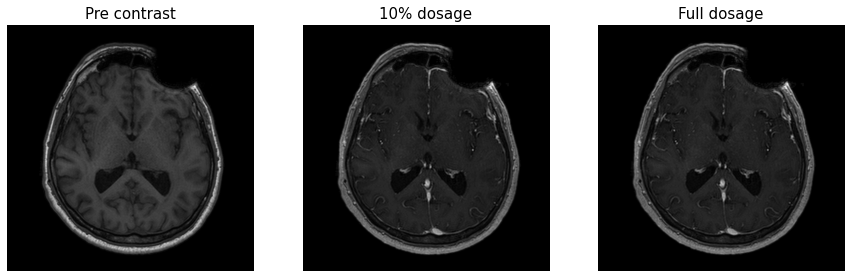

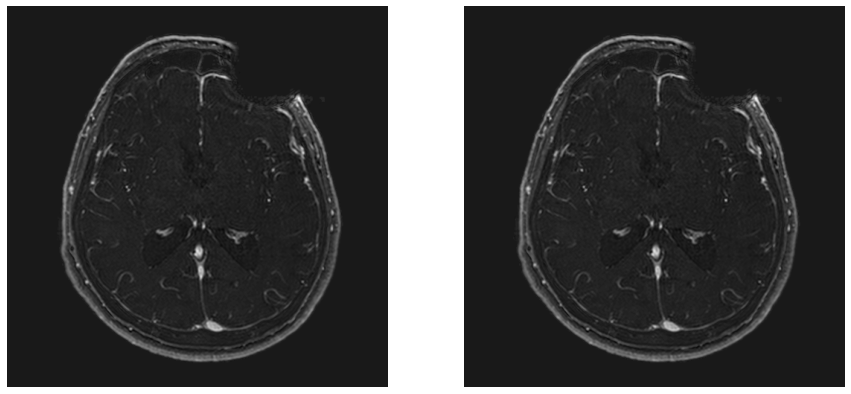

In [19]:
iminfo(ims[90, 0])
iminfo(ims[90, 1])
iminfo(ims[90, 2])

show_gad_comparison(ims[90, 0], ims[90, 1], ims[90, 2])

pre_diff = diff_img(orig_ims[90, 0], ims[90, 0])
low_diff = diff_img(orig_ims[90, 1], ims[90, 1])
post_diff = diff_img(orig_ims[90, 2], ims[90, 2])

# show_gad_comparison(pre_diff, low_diff, post_diff)

show_comparison(ims[90, 1] - ims[90, 0], ims[90, 2] - ims[90, 0])

### FSL Mask

In [ ]:
fsl_mask = fsl_brain_mask(args)
ims = apply_fsl_mask(args, ims, fsl_mask)

### Histogram normalization

In [20]:
orig_ims = np.copy(ims)
ims, metadata = hist_norm(args, ims, metadata)

Histogram normalization
histogram data type float32
image intensity normalization
scaling done, 2.87 s
image intensity normalization
scaling done, 2.68 s


In [ ]:
vmin = ims[:, 0].min()
vmax = ims[:, 0].max()

diff = np.abs(ims[:, 0] - ims[:, 2])
vmin, vmax = (diff.min(), diff.max())

th = diff.max() * 0.25
mask = diff >= th

full_masked = (ims[:, 2] * mask)

recon = ims[:, 0] + full_masked

x1=280
x2=340
y1=360
y2=420

im1 = ims[pidx, 0]
im2 = ims[pidx, 1]
im3 = ims[pidx, 2]

stack = np.hstack([im1, im3])

fig, ax = plt.subplots(1)
ax.imshow(stack, vmin=vmin, vmax=vmax)
rect = Rectangle((180, 375), 20, 20, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

p1 = im1[160:180, 355:375]
p2 = im3[160:180, 355:375]

print(p1.mean(), p2.mean())

show_comparison(p1, p2)
#show_comparison(im1, im3, vmin=vmin, vmax=vmax)

(512, 512) float32 0.0 482.0 47.16848
(512, 512) float32 0.0 641.2439 44.673733
(512, 512) float32 0.0 641.24146 44.67623


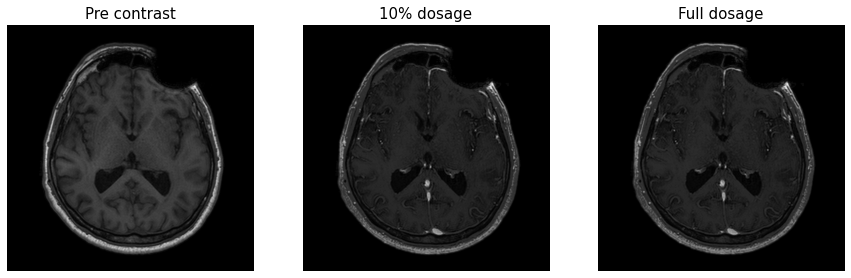

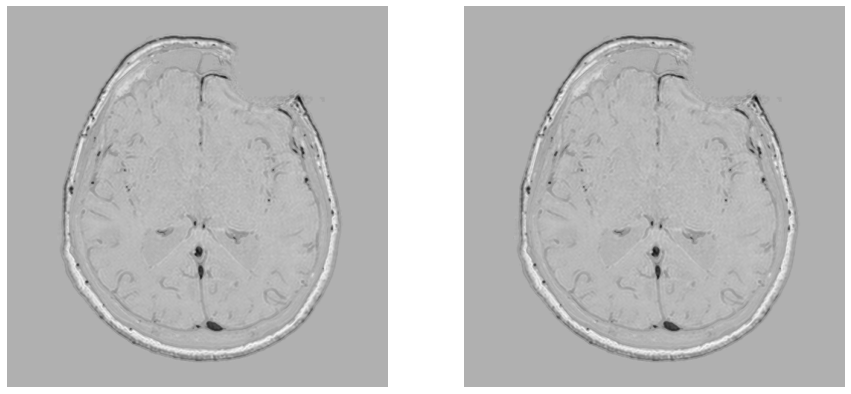

In [22]:
iminfo(ims[90, 0])
iminfo(ims[90, 1])
iminfo(ims[90, 2])

show_gad_comparison(ims[90, 0], ims[90, 1], ims[90, 2])
show_comparison(diff_img(ims[90, 0], ims[90, 1]), diff_img(ims[90, 0], ims[90, 2]))

### Zoom

In [ ]:
args.zoom = 512
args.zoom_order = 1

ims_zoom, metadata = zoom_process(args, ims, metadata)

In [ ]:
iminfo(ims_zoom)
show_gad_comparison(ims_zoom[172, 0], ims_zoom[172, 1], ims_zoom[172, 2])

### Match scales and global normalization

In [23]:
orig_ims = np.copy(ims)

ims, ims_mod, metadata = prescale_process(args, ims, mask, metadata)
ims, ims_mod, metadata = match_scales(args, ims, ims_mod, metadata)
ims, metadata = global_norm(args, ims, ims_mod, metadata)

intensity before scaling:
mean [96.21063 91.1077  91.08924]
median [95.      86.49629 86.48747]
max [485.      724.01697 724.0148 ]
scale low: 1.141190700725737
scale full: 1.1413547090901635
done scaling data (2.57 s)
intensity after scaling:
mean [ 96.21063  103.920265 103.9097  ]
median [95.      98.70876 98.71288]
max [485.      826.2414  826.35767]
normalizing with function  mean <function mean at 0x7f1ad018ebf8>
intensity before global scaling:
mean [ 96.21063  103.920265 103.9097  ]
median [95.      98.70876 98.71288]
max [485.      826.2414  826.35767]
global scaling: [[ 96.21063  103.920265 103.9097  ]]
done (0.26s)
intensity after global scaling:
mean [0.99773246 0.99971825 1.000155  ]
median [0.98741686 0.949851   0.9499872 ]
max [5.041023  7.9507246 7.952652 ]


(180, 512, 512) float32 0.0 14.925586 0.44314793
(180, 512, 512) float32 0.0 15.7692995 0.4749815
(180, 512, 512) float32 0.0 15.77317 0.47513145


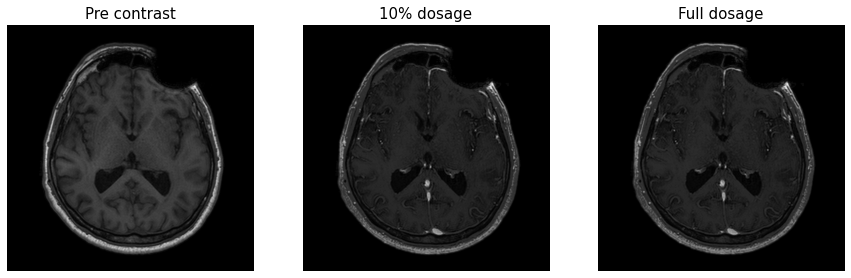

In [25]:
iminfo(ims[:, 0])
iminfo(ims[:, 1])
iminfo(ims[:, 2])

show_gad_comparison(ims[90, 0], ims[90, 1], ims[90, 2])

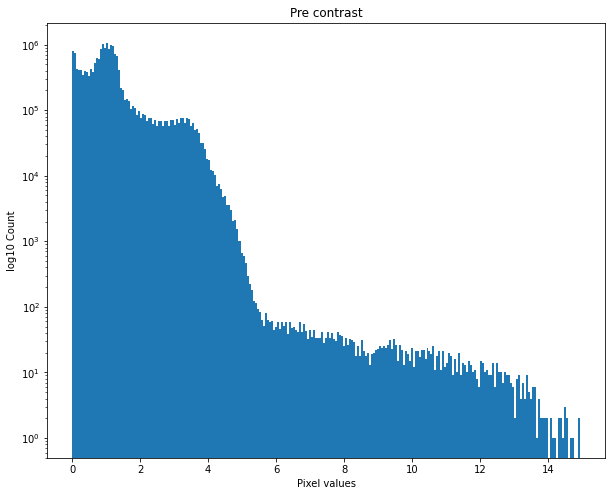

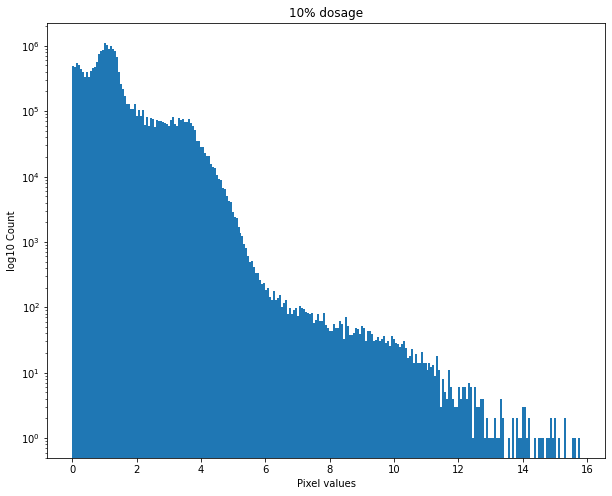

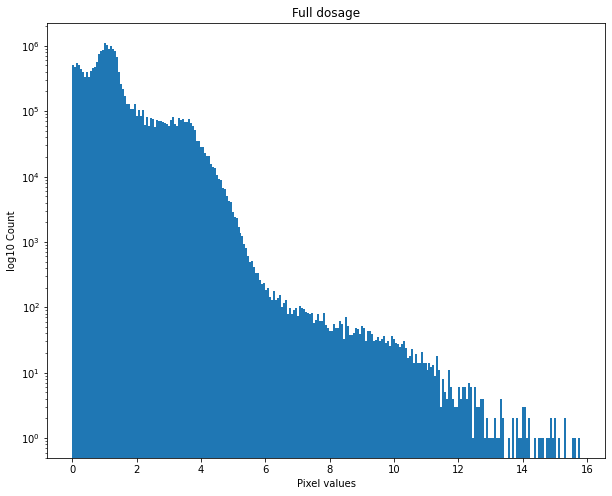

In [26]:
show_hist(ims[:, 0], nbins=255, title='Pre contrast')
show_hist(ims[:, 1], nbins=255, title='10% dosage')
show_hist(ims[:, 2], nbins=255, title='Full dosage')

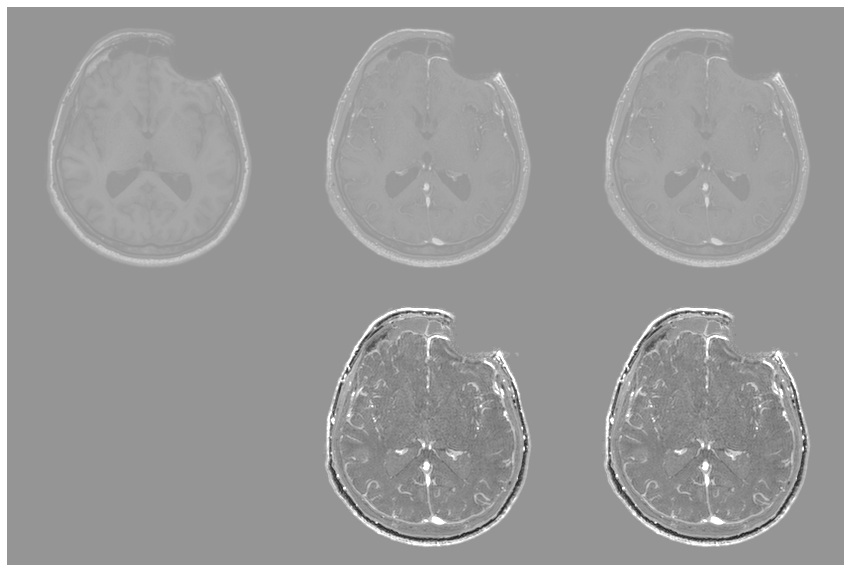

In [27]:
show_final_comparison(ims[90, 0], ims[90, 1], ims[90, 2])

In [ ]:
pp_data = suio.load_file('/home/srivathsa/projects/studies/gad/stanford/preprocess/data/Patient_0089.npy')
pp_mask = pp_data[1]

In [ ]:
plt.imshow(pp_mask[160, 1] - pp_mask[160, 0])

In [ ]:
base_path = '/raid/srivathsa/stanford/preprocess/data'
dest_path = '/raid/srivathsa/stanford/preprocess/data/f16'

fpaths = sorted([f for f in glob('{}/*.npy'.format(base_path))])
for fpath in tqdm(fpaths, total=len(fpaths)):
    try:
        cnum = fpath.split('/')[-1].replace('.npy', '')
        data = np.load(fpath)
        np.save('{}/{}.npy'.format(dest_path, cnum), data.astype(np.float16))
        os.remove(fpath)
        print('Saved float16 data for {}...'.format(cnum))
    except Exception as e:
        print('ERROR while processing {}: {}...'.format(cnum, e))

In [79]:
data = suio.load_file('/home/srivathsa/projects/studies/gad/tiantan/preprocess/data/NO118.h5', 
                      params={'h5_key': 'all'})[0]
data = data.transpose(1, 2, 0, 3)
data = np.rot90(data, k=3, axes=(2, 3))
pre, low, full = data

pre = pre / 16.0
low = low / 16.0
full = full / 16.0

print(data.shape)

(3, 240, 240, 196)


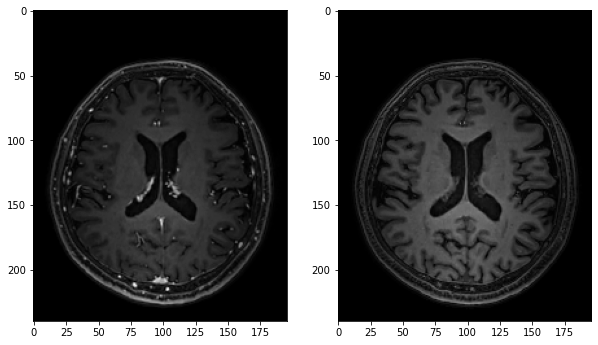

In [83]:
sl = 83
# plt.imshow(np.hstack([full[sl], pre[sl]]))

fig, ax = plt.subplots(1, 2)
ax[0].imshow(full[sl], vmin=full[sl].min(), vmax=full[sl].max())
ax[1].imshow(pre[sl], vmin=full[sl].min(), vmax=full[sl].max())

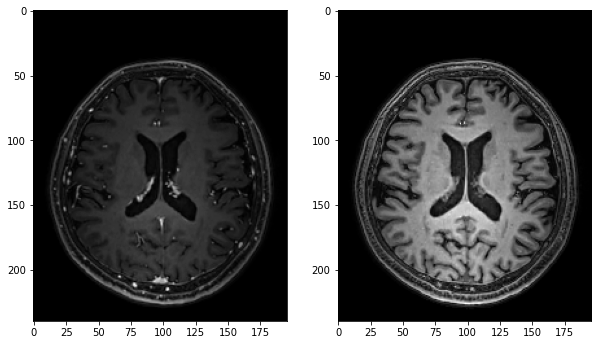

In [84]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(full[sl])
ax[1].imshow(pre[sl])

In [56]:
print(full.min(), full.max())

0.0 0.570959


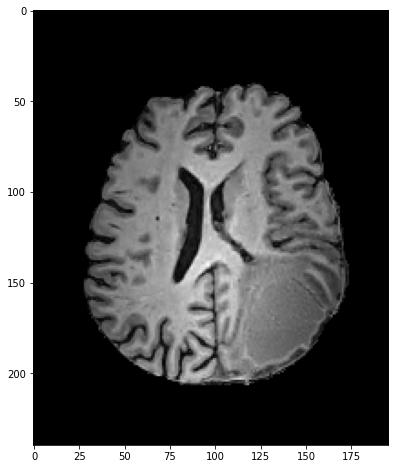

In [70]:
img = np.load('/home/dayang/data2d/100_72_train.npy')
plt.imshow(img[0])